# The EM Algorithm for Gaussian Mixtures
### Maks Cegielski-Johnson & Jake Pitkin

**CS 6190: Probabilistic Modeling - Spring 2018**<br>
**April 27 2018**

## Introduction

We will be exploring the EM (Expectation-Maximization) algorithm for Gaussian mixtures. The EM algorithm is an iterative method that alternates between an E step and a M step. In the E step an expectation of the log-likelihood is calculated using the current estimate for the parameters. Then in the M step, new parameters are computed to maximize the expected log-likelihood from the previous step. This continues for some given number of epochs.

We will start with a proof of correctness for the EM algorithm with Gaussian mixtures, followed by an implimentation in Python, and closing with some experiments testing the effectiveness of the algorithm.

## Proof of Correctness

Let's restate the general EM algorithm. First, we had the E-step:
$$Q(\theta, \hat{\theta}^{(t)}) = \mathbb{E}_{z \mid x; \hat{\theta}^{(t)}}
\big[\ln L(\theta; x,z)\big]$$
Where $z$ are latent variables, and $x$ are observed variables. Then, the M-step is
$$\theta^{(t+1)} = \arg\max_{\theta} Q(\theta, \hat{\theta}^{(t)})$$

We want to apply this algorithm to our Gaussian Mixture Model, where
$$p(x_i \mid z_i) = \prod_{j=1}^{J} \mathcal{N}(x_i \mid \mu_j, \Sigma_j)^{z_{ij}}$$
where $J$ is the number of labels (or Gaussians) we have. We have
$$p(z_{ij} = 1) = \tau_{j}$$
where $\tau_j$ is a probability vector. This gives us 
$$p(z_{i}) = \prod_{j=1}^J = \tau_j^{z_{ij}}$$

We can draw the variable diagram as
![title](img/fig1.png)

Next, we can compute the likelihood as

\begin{align*}
L(\theta; x,z) &= \prod_{i=1}^N p(x_i \mid z_i; \theta)p(z_i;\theta)\\
&= \prod_{i=1}^N\prod_{j=1}^J \tau_j^{z_{ij}} \mathcal{N}(x_i; \mu_j, \Sigma_j)^{z_{ij}}
\end{align*}

Then, for our E-step we need to compute the log likelihood,

$$\ln(L(\theta; x,z)) = \sum_{i=1}^N\sum_{j=1}^J z_{ij}\Big(\ln\tau_j + \ln \mathcal{N}(x_i; \mu_j, \Sigma_j)\Big)$$
And we need to compute
\begin{align*}
p(z_{ij} = 1 \mid x_i; \hat{\theta}^{(t)}) &= \frac{p(x_i \mid z_{ij})P(z_{ij} = 1)}{p(x_i)}\\
&= \frac{\hat{\tau}_j \mathcal{N}(x_i; \hat{\mu_j}, \hat{\Sigma_j})}{\sum_{j=1}^{J} \hat{\tau}_j \mathcal{N}(x_i; \hat{\mu_j}, \hat{\Sigma_j})}\\
&\hat{=}~ p_{ij}
\end{align*}

Then
\begin{align*}
Q(\theta, \hat{\theta}^{(t)}) &= \mathbb{E}_{z \mid x; \hat{\theta}^{(t)}}
\Bigg[ \sum_{i=1}^N\sum_{j=1}^J z_{ij}\Big(\ln\tau_j + \ln \mathcal{N}(x_i; \mu_j, \Sigma_j)\Big)\Bigg]\\
&=  \sum_{i=1}^N\sum_{j=1}^J \Big(\ln\tau_j + \ln \mathcal{N}(x_i; \mu_j, \Sigma_j)\Big)\mathbb{E}_{z \mid x; \hat{\theta}^{(t)}}[z_{ij}]
\end{align*}
and $\mathbb{E}_{z \mid x; \hat{\theta}^{(t)}}[z_{ij}] = p_{ij}$.

Now for the M-step, we want to calculate $\frac{d}{\mu_j}$, $\frac{d}{\Sigma_j}$, and $\frac{d}{\tau_j}$.

\begin{align*}
0 &= \frac{d}{\mu_j} \sum_{i=1}^N\sum_{j=1}^J \Big(\ln\tau_j + \ln \mathcal{N}(x_i; \mu_j, \Sigma_j)\Big) p_{ij}\\
&= \sum_{i=1}^N\sum_{j=1}^J p_{ij} (\mu_j - x_{i})\\
&= \sum_{i=1}^N p_{ij}\mu_j - \sum_{i=1}^N p_{ij}x_{i}\\
\mu_j &= \frac{\sum_{i=1}^N p_{ij}x_{i}}{\sum_{i=1}^N p_{ij}}
\end{align*}
And similarly
\begin{align*}
0 &= \frac{d}{\Sigma_j} \sum_{i=1}^N\sum_{j=1}^J \Big(\ln\tau_j + \ln \mathcal{N}(x_i; \mu_j, \Sigma_j)\Big) p_{ij}\\
\Sigma_j &= \frac{\sum_{i=1}^N p_{ij}(x_i - \mu_j)(x_i - \mu_j)^T}{\sum_{i=1}^N p_{ij}}
\end{align*}
Finally to find $\frac{d}{\tau_j}$, we need $\frac{j=1}{J} \tau_j = $, therefore we have to use Lagrange multipliers to enforce this constraint. 

\begin{align*}
0 &= \frac{d}{d \tau_j} \sum_{i=1}^{N}\sum_{j=1}^J p_{ij} \ln \tau_j + \lambda (\sum_{j=1}^J \tau_j - 1)\\
&= \sum_{i=1}^N \frac{p_{ij}}{\tau_j} + \lambda 
\tau_j &= \frac{\sum_{i=1}^N p_{ij}}{-\lambda}
\end{align*}
And we set $\lambda = -N$, giving us
$$\tau_j = \frac{\sum_{i=1}^N p_{ij}}{N}$$
Using these derivation for the parameters gives us the M-step. 

Now, we can use both E and M steps to get an algorithm to classify our data. 

## Implimentation 

Below is our implimentation of the EM algorithm for Gaussian Mixtures.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import scipy.stats as stats
import matplotlib.cm as cm

## EM Algorithm Implementation ##
def em(data, classes, epoch):
    sample_mean = np.average(data, axis=0)
    component_variance = 1.0/len(data)*sum((data - sample_mean)**2)
    mu = [data[np.random.choice(range(data.shape[0]))] for i in range(classes)]
    sigma2 = [component_variance for i in range(classes)]
    psi = [1.0/classes for i in range(classes)]
    for i in range(epoch):
        gamma = e_step(data, classes, mu, sigma2, psi)
        mu,sigma2,psi = m_step(data,classes,gamma)
    return gamma

def e_step(data, classes, mu, sigma2, psi):
    gamma = np.zeros((len(data), classes))
    for i in range(len(data)):
        normals = [psi[k]*stats.multivariate_normal.pdf(data[i], mu[k], np.diag(sigma2[k]), allow_singular=True)\
                     for k in range(classes)] 
        for k in range(classes):
            if sum(normals) != 0:
                gamma[i][k] = normals[k]/sum(normals)
            else:
                gamma[i][k] = normals[k]/0.001
    return gamma


def m_step(data, classes, gamma):
    sumGamma = [sum(gamma[:,k]) for k in range(classes)]
    psi = [sumGamma[k]/data.shape[0] for k in range(classes)]
    mu = [scalarSum(gamma[:,k], data)/sumGamma[k] for k in range(classes)]
    sigma2 = [scalarSquareSum(gamma[:,k], data, mu[k])/sumGamma[k] for k in range(classes)]
    return mu, sigma2, psi

def scalarSum(gamma, x):
    total = np.zeros(x[0].shape)
    for i in range(x.shape[0]):
        total += gamma[i]*x[i]
    return total

def scalarSquareSum(gamma, x, m):
    total = np.zeros(x[0].shape)
    for i in range(x.shape[0]):
        total += gamma[i]*(x[i] - m)**2
    return total

## Testing the model

First we will generate some easy data to cluster and test the EM algorithms ability to cluster it. The data is 300 generated points, in two dimentions and clustered into three groups. The EM algorithm will predict a cluster for each point and color the point accordingly.

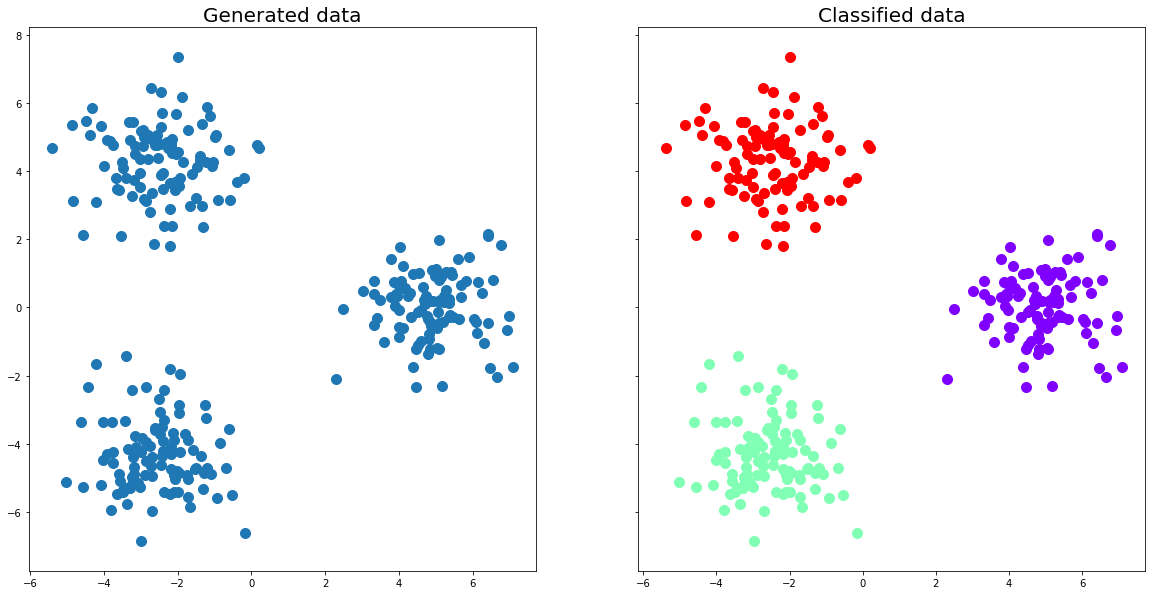

In [2]:
def generateData(dimension, amount, classes):
    dimension = 2
    centers = []
    r = 5.0
    for i in range(classes):
        centers.append(np.array([r * np.cos(2 * np.pi * i / classes), r * np.sin(2 * np.pi * i / classes)]))
    data = []
    labels = []
    for sample in range(amount):
        center = np.random.choice(range(classes))
        labels.append(center)
        C = centers[center]
        data.append(np.array([np.random.normal(C[0],1.0), np.random.normal(C[1], 1.0)]))
    return np.array(data),labels
data,labels = generateData(dimension=2,amount=300,classes=3)

# Cluster the generated data
probs = em(data, classes=3, epoch=50)
predictions = np.array([np.argmax(probs[i]) for i in range(probs.shape[0])])
colors = cm.rainbow(np.linspace(0, 1, 3))

# Plot the cluster predictions
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(20,10))
ax1.scatter([k[0] for k in data],[k[1] for k in data], s=100)
ax1.set_title('Generated data', fontsize=20)
ax2.set_title('Classified data', fontsize=20)
for i in range(3):
    indices = np.where(predictions == i)
    points = np.take(data,indices,axis=0)[0]
    ax2.scatter([k[0] for k in points],[k[1] for k in points], color=colors[i], s=100)
plt.show()

We see that the EM algorithm does a great job on data that: is low dimension, there are a small number of clusters, and there is no noise.

Now, let's test it on the classic Iris dataset. The Iris dataset contains three types of Iris: Setosa, Versicolor, and Virginica. For each Iris there are 5 features: sepal length, sepal width, petal length, petal width, and a bias term. Since five dimensions is difficult to visualize, we will be using a _Purity_ evaluation of the clustering:

$$Purity = \frac{1}{N} \sum_{i = 1}^k \max_j | c_i \cap l_j|$$

Where $N$ is the number of samples, $k$ is the number of clusters, $c_i$ is a cluster, and $l_j$ are the labels for the data. Essentially _purity_ is a score from $[0,1]$ that expresses how well samples with identical labels are clustered together.

In [3]:
def purity(n_classes, predictions, labels):
    """ Computes the purity of a cluster prediction. """
    conf_matrix = [[0 for i in range(n_classes)] for j in range(n_classes)]
    for j in range(n_classes):
        indices = np.where(predictions == j)[0]
        for index in indices:
            conf_matrix[j][labels[index]] += 1
    result = 0
    for entry in conf_matrix:
        result += max(entry)
    return conf_matrix, result / len(labels)

# Read in the dataset
iris = pd.read_csv("data/iris-3.csv")
iris.columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'label']
iris['label'] = iris['label'].replace(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], [0, 1, 2])

# Create feature vectors and labels
iris_vectors = []
labels = []
for row in iris.iterrows():
    iris_vectors.append(np.array([1, row[1][0], row[1][1], row[1][2], row[1][3]]))
    labels.append(int(row[1][4]))
labels = np.array(labels)
data = np.array(iris_vectors)

# EM algorithm on the iris data with two classes and two features
probabilities = em(data, classes=3, epoch=50)
predictions = np.array([np.argmax(probabilities[i]) for i in range(probabilities.shape[0])])

conf_matrix, purity = purity(3, predictions, labels)

%matplotlib inline
df = pd.DataFrame()
df['Setosa'] = conf_matrix[0]
df['Versicolor'] = conf_matrix[1]
df['Virginica'] = conf_matrix[2]
print("Confusion Matrix for the Iris dataset:")
display(df)
print("Purity of clustering: {}".format(round(purity,4)))

Confusion Matrix for the Iris dataset:


,Setosa,Versicolor,Virginica
0,0,0,50
1,43,7,0
2,2,48,0


Purity of clustering: 0.94
